In [273]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

global_config = md.global_config


## most recents

In [79]:
run_id_base = "251021_GEN_"
repetitions = 5
combos = ["110","101","011"] #1 is training data, 0 test. logic is LSB: 001 -> SITE1 is training data. 
run_ids = []
for i in range(repetitions): # Run 10 experiments with different seeds
    for combo in combos:
        #run_id = md.generate_run_id()
        run_id = run_id_base + f"_{combo}_{i}"
        run_ids.append(run_id)

#run_ids = ["251021_GEN__"]

In [80]:
run_ids

['251021_GEN__110_0',
 '251021_GEN__101_0',
 '251021_GEN__011_0',
 '251021_GEN__110_1',
 '251021_GEN__101_1',
 '251021_GEN__011_1',
 '251021_GEN__110_2',
 '251021_GEN__101_2',
 '251021_GEN__011_2',
 '251021_GEN__110_3',
 '251021_GEN__101_3',
 '251021_GEN__011_3',
 '251021_GEN__110_4',
 '251021_GEN__101_4',
 '251021_GEN__011_4']

In [168]:
# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        if not os.path.exists(exp_dir):
            print(f"Experiment directory does not exist for run_id {run_id}. Skipping...")
            continue

        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        print("Available experiments:", experiment_names)

    df_result = pd.DataFrame()
    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test)
        df_result = eval.write_metrics_to_df(report, sites, cfg, df=df_result)
        
        # print("===========================")
        # print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
        #eval.print_all_metrics(report, sites, cfg, above2m=True)
        #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
        eval.printout_eval_report(report, sites, cfg, run_id)
        #print("====================================")

        # Print the evaluation report
    #print(df_result.transpose().to_string())
    eval.save_df_result_to_csv(df_result, run_id, override=True)


  0%|          | 0/15 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']


  7%|▋         | 1/15 [00:05<01:14,  5.36s/it]

Results saved to ../results/251021_GEN__110_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']


 13%|█▎        | 2/15 [00:08<00:54,  4.18s/it]

Results saved to ../results/251021_GEN__101_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']


 20%|██        | 3/15 [00:12<00:47,  3.97s/it]

Results saved to ../results/251021_GEN__011_0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']


 27%|██▋       | 4/15 [00:16<00:43,  3.96s/it]

Results saved to ../results/251021_GEN__110_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']


 33%|███▎      | 5/15 [00:19<00:37,  3.78s/it]

Results saved to ../results/251021_GEN__101_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']


 40%|████      | 6/15 [00:23<00:34,  3.85s/it]

Results saved to ../results/251021_GEN__011_1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']


 47%|████▋     | 7/15 [00:27<00:29,  3.70s/it]

Results saved to ../results/251021_GEN__110_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']


 53%|█████▎    | 8/15 [00:31<00:26,  3.76s/it]

Results saved to ../results/251021_GEN__101_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']


 60%|██████    | 9/15 [00:34<00:22,  3.76s/it]

Results saved to ../results/251021_GEN__011_2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']


 67%|██████▋   | 10/15 [00:38<00:19,  3.81s/it]

Results saved to ../results/251021_GEN__110_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']


 73%|███████▎  | 11/15 [00:43<00:15,  3.93s/it]

Results saved to ../results/251021_GEN__101_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']


 80%|████████  | 12/15 [00:46<00:11,  3.88s/it]

Results saved to ../results/251021_GEN__011_3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']
['_110']
Categories (1, object): ['_110']


 87%|████████▋ | 13/15 [00:50<00:07,  3.82s/it]

Results saved to ../results/251021_GEN__110_4/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']
['_101']
Categories (1, object): ['_101']


 93%|█████████▎| 14/15 [00:56<00:04,  4.53s/it]

Results saved to ../results/251021_GEN__101_4/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']
['_011']
Categories (1, object): ['_011']


100%|██████████| 15/15 [01:00<00:00,  4.04s/it]

Results saved to ../results/251021_GEN__011_4/metrics/results_summary.csv


In [170]:
df_big = eval.read_multiple_csv_to_df(run_ids)

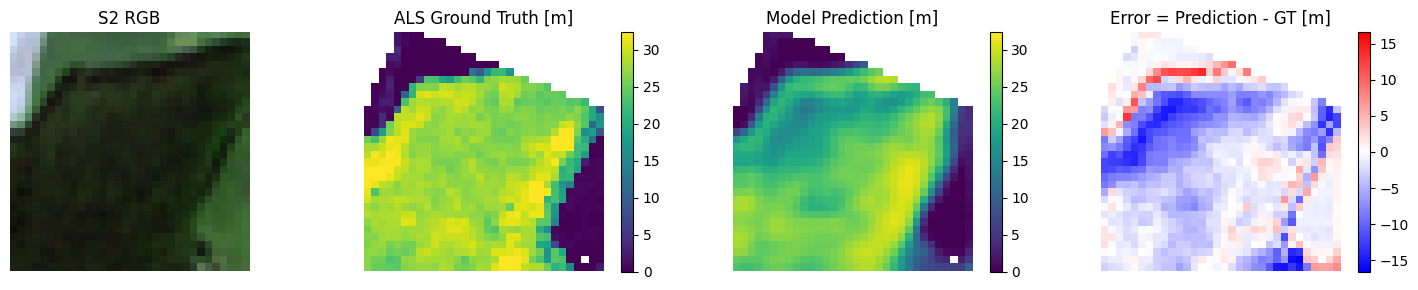

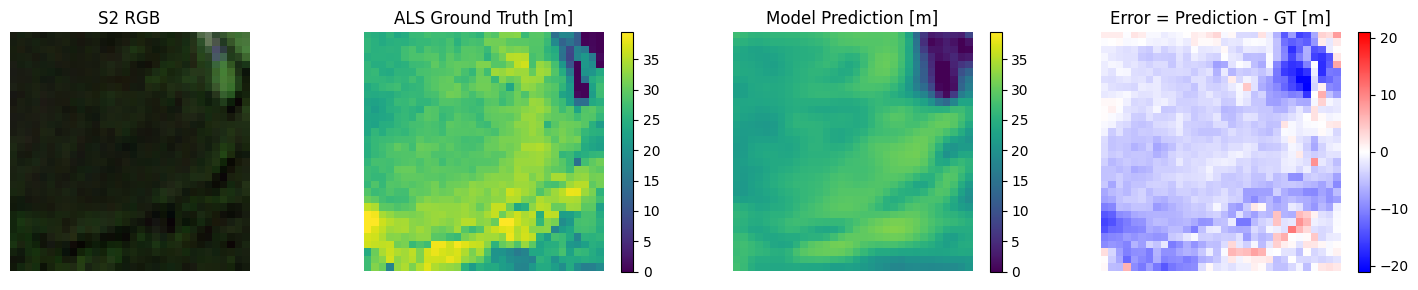

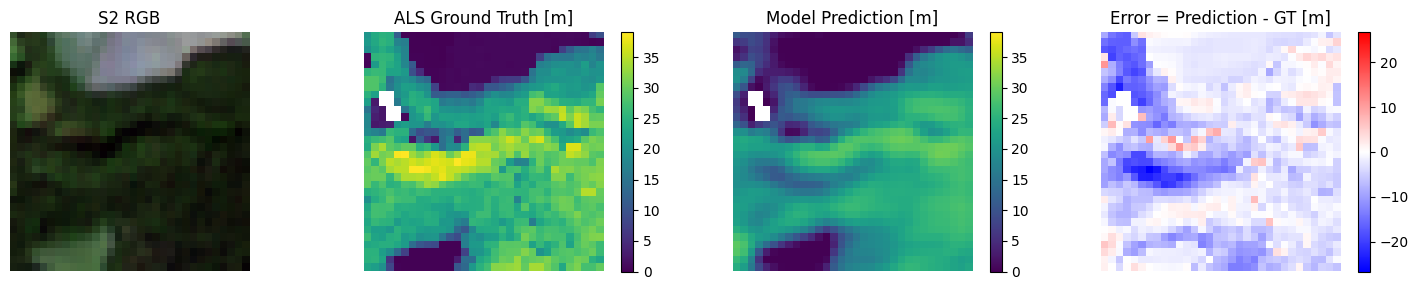

In [84]:
eval.plot_real_pred_delta(report, num_samples=3)

## plot metrics

In [162]:
df_result

,Experiment,MAE [m] (Val),MAE [m] (Test),nMAE [%] (Val),nMAE [%] (Test),RMSE [m] (Val),RMSE [m] (Test),Bias [m] (Val),Bias [m] (Test),R2 [-] (Val),...,weight_decay,scheduler_type,scheduler_patience,scheduler_factor,scheduler_min_lr,early_stopping_patience,epochs,huber_delta,device,combo
0,01_baseline,5.35,5.94,30.85,25.64,7.26,7.93,0.83,-4.32,0.62,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
1,02_pixel_composites,5.05,5.03,27.79,22.09,6.85,7.09,0.42,-2.38,0.67,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
2,03_seasonal_composites,4.28,4.77,19.69,20.90,5.92,6.11,0.10,-2.04,0.73,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
3,04_pixel_and_seasonal_comp,4.37,6.14,20.02,24.72,5.95,7.69,0.41,-4.98,0.73,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
4,05_support_fmask_dlt,4.40,5.60,19.78,22.79,5.94,7.12,0.23,-4.24,0.73,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
5,06_support_fmask_dlt_dem,4.30,5.32,19.12,21.78,5.83,6.80,0.01,-3.72,0.74,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011
6,07_aux_task,4.35,5.35,19.81,21.94,5.88,7.18,0.37,-3.43,0.73,...,0.0002,ReduceLROnPlateau,15,0.5,0.000001,75,500,1.35,mps,011


In [172]:
df_big["combo"].unique()

array(['_110', '_101', '_011'], dtype=object)

In [249]:
target_folder = "gen/test1"
stats = eval.save_big_df_stats(run_ids=run_ids, target_folder=target_folder)

Generalization results saved to ../results/gen/test1/metrics/results_summary.csv


In [177]:
run_ids = ["251009_600_"+str(i) for i in range(5)]
target_folder = "all_in/test1"
stats = eval.save_big_df_stats(run_ids=run_ids, target_folder=target_folder)

Generalization results saved to ../results/all_in/test1/metrics/results_summary.csv


In [207]:
gen_path = "../results/gen/test1/metrics/results_summary.csv"
allin_path = "../results/all_in/test1/metrics/results_summary.csv"

gen_df = pd.read_csv(gen_path) # only column combo as dtype categorical
allin_df = pd.read_csv(allin_path)

master_df = pd.concat([gen_df, allin_df], ignore_index=True)
master_df = master_df.melt(id_vars=["Experiment", "combo"], 
                           var_name="Metrics", 
                           value_name="Value")

In [215]:
dfgs = eval.generalization_checker(gen_path=gen_path,allin_path=allin_path)
dfgs = dfgs[dfgs["Score_Type"]=="mean_score"]

<string>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [ ]:
master_df

                     Experiment   combo              Metrics  Value
0                   01_baseline    _011  MAE [m] (Test) Mean  5.472
1                   01_baseline    _101  MAE [m] (Test) Mean  5.718
2                   01_baseline    _110  MAE [m] (Test) Mean  7.680
3           02_pixel_composites    _011  MAE [m] (Test) Mean  4.698
4           02_pixel_composites    _101  MAE [m] (Test) Mean  6.070
..                          ...     ...                  ...    ...
415      03_seasonal_composites  _allin  R2 [-] (Test) Count  5.000
416  04_pixel_and_seasonal_comp  _allin  R2 [-] (Test) Count  5.000
417        05_support_fmask_dlt  _allin  R2 [-] (Test) Count  5.000
418    06_support_fmask_dlt_dem  _allin  R2 [-] (Test) Count  5.000
419                 07_aux_task  _allin  R2 [-] (Test) Count  5.000

[420 rows x 4 columns]


In [212]:
dfgs

,Experiment,Metric,combo,Score,Score_Type
0,01_baseline,MAE [m] (Test),_011,66.861314,mean_score
1,01_baseline,MAE [m] (Test),_011,2.257878,std_factor
2,01_baseline,nMAE [%] (Test),_011,71.704146,mean_score
3,01_baseline,nMAE [%] (Test),_011,2.057550,std_factor
4,01_baseline,RMSE [m] (Test),_011,66.560284,mean_score
...,...,...,...,...,...
163,07_aux_task,nMAE [%] (Test),_110,1.660450,std_factor
164,07_aux_task,RMSE [m] (Test),_110,-51.001180,mean_score
165,07_aux_task,RMSE [m] (Test),_110,2.407886,std_factor
166,07_aux_task,R2 [-] (Test),_110,-286.614176,mean_score


In [254]:
fig = eval.plot_genscore(dfgs, printout=False, targetfolder="test1")

In [253]:
fig = eval.plot_comparison_all_gen(master_df, targetfolder="test1")

# old stuff

In [293]:
def plot_experiment_matrix(experiments, order_exps=None, figsize=(14, 6), cmap="Greens"):
  """
  Visualize experiment configs as a binary/config matrix.
  Rows = experiments (index), Columns = features:
    - spectral seasons (prefixed 'season:')
    - spectral quantiles (prefixed 'quantile:')
    - aux inputs (prefixed 'aux:')
    - outputs (prefixed 'out:'; annotated with loss/weight when available)
    - strategy (prefixed 'strategy:')
  A colored cell indicates presence; annotation shows 'x' for simple presence
  or for outputs shows "<loss>|w=<weight>" if available.

  Args:
    experiments (dict): mapping experiment_name -> config dict
    order_exps (list, optional): list of experiment names to control row order
    figsize (tuple): matplotlib figure size
    cmap (str): colormap for seaborn.heatmap
  Returns:
    pd.DataFrame: binary presence matrix (0/1)
  """
  # collect experiment names
  exp_names = list(experiments.keys()) if order_exps is None else order_exps
  # gather all possible columns
  seasons = set()
  quantiles = set()
  aux_inputs = set()
  outputs = set()
  strategies = set()

  for name in exp_names:
    cfg = experiments.get(name, {})
    spec = cfg.get("spectral", {}) or {}
    s = spec.get("seasons", []) or []
    q = spec.get("quantiles", []) or []
    for si in s: seasons.add(si)
    for qi in q: quantiles.add(qi)
    for ai in (cfg.get("aux_inputs") or []): aux_inputs.add(ai)
    for out_name in (cfg.get("outputs") or {}).keys(): outputs.add(out_name)
    strategies.add(cfg.get("strategy", "None"))

  # build ordered column list
  col_list = []
  # strategy columns (one-hot)
  strat_cols = [f"strategy:{s}" for s in sorted(strategies)]
  col_list.extend(strat_cols)
  # spectral
  season_cols = [f"season:{s}" for s in sorted(seasons)]
  quantile_cols = [f"quantile:{q}" for q in sorted(quantiles)]
  col_list.extend(season_cols)
  col_list.extend(quantile_cols)
  # aux inputs
  aux_cols = [f"aux:{a}" for a in sorted(aux_inputs)]
  col_list.extend(aux_cols)
  # outputs
  out_cols = [f"out:{o}" for o in sorted(outputs)]
  col_list.extend(out_cols)

  # prepare matrices
  mat = pd.DataFrame(0, index=exp_names, columns=col_list, dtype=int)
  annot = pd.DataFrame("", index=exp_names, columns=col_list)

  for name in exp_names:
    cfg = experiments.get(name, {}) or {}
    # strategy
    strat = cfg.get("strategy", None)
    if strat is not None:
      col = f"strategy:{strat}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # spectral
    spec = cfg.get("spectral", {}) or {}
    for s in spec.get("seasons", []) or []:
      col = f"season:{s}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    for q in spec.get("quantiles", []) or []:
      col = f"quantile:{q}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # aux inputs
    for a in cfg.get("aux_inputs", []) or []:
      col = f"aux:{a}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "✔"
    # outputs: annotate with loss and weight if present
    for out_name, out_cfg in (cfg.get("outputs") or {}).items():
      col = f"out:{out_name}"
      if col in mat.columns:
        mat.at[name, col] = 1
        loss = out_cfg.get("loss")
        weight = out_cfg.get("weight")
        if loss is None and weight is None:
          annot.at[name, col] = "x"
        else:
          pieces = []
          if loss is not None:
            if loss == "crossentropy":
              loss = "ce"
            pieces.append(str(loss))
          # if weight is not None:
          #   pieces.append(f"w={weight}")
          annot.at[name, col] = "|".join(pieces)

  # Plot with seaborn heatmap and string annotations
  import seaborn as sns  # seaborn is available in notebook; import again is harmless
  plt.figure(figsize=figsize)
  ax = sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="#dddddd",
       annot=annot.values, fmt="", annot_kws={"fontsize": 12}, vmin=0, vmax=3)
  ax.set_ylabel("")  # experiments are rows already
  ax.set_xlabel("")  # columns explain themselves
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

  # Add bold vertical lines
  strategy_end = len(strat_cols)
  inputs_end = strategy_end + len(season_cols) + len(quantile_cols) + len(aux_cols)
  ax.axvline(x=strategy_end, color="black", linewidth=2)  # Line after strategy
  ax.axvline(x=inputs_end, color="black", linewidth=2)    # Line after all inputs
  ax.axhline(y=1, color="black", linewidth=2) 
  ax.axhline(y=4, color="black", linewidth=2) 
  ax.axhline(y=6, color="black", linewidth=2) 



  plt.title("Experiment configuration mapping")
  plt.tight_layout()
  plt.show()

  return mat

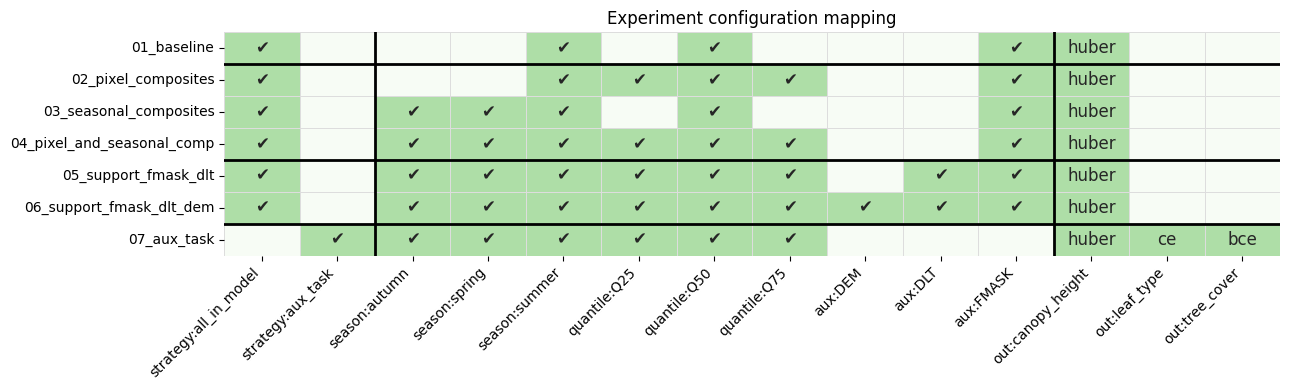

,strategy:all_in_model,strategy:aux_task,season:autumn,season:spring,season:summer,quantile:Q25,quantile:Q50,quantile:Q75,aux:DEM,aux:DLT,aux:FMASK,out:canopy_height,out:leaf_type,out:tree_cover
01_baseline,1,0,0,0,1,0,1,0,0,0,1,1,0,0
02_pixel_composites,1,0,0,0,1,1,1,1,0,0,1,1,0,0
03_seasonal_composites,1,0,1,1,1,0,1,0,0,0,1,1,0,0
04_pixel_and_seasonal_comp,1,0,1,1,1,1,1,1,0,0,1,1,0,0
05_support_fmask_dlt,1,0,1,1,1,1,1,1,0,1,1,1,0,0
06_support_fmask_dlt_dem,1,0,1,1,1,1,1,1,1,1,1,1,0,0
07_aux_task,0,1,1,1,1,1,1,1,0,0,0,1,1,1


In [294]:
plot_experiment_matrix(experiments, figsize=(13, 4), cmap="Greens")